In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
from collections import Counter
import matplotlib.image as mpimg

In [2]:
base_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(base_dir, 'data')
print(data_dir)

/home/ec2-user/vqa-project/data


In [3]:
os.listdir(data_dir)

['features_rn50',
 'train.zip',
 'val.zip',
 'test.zip',
 'train',
 'val',
 'test',
 'Annotations.zip',
 'class_mapping.csv',
 'test.json',
 'train.json',
 'val.json']

In [4]:
# Reading train and validation data
train_data = pd.read_json(data_dir+"/train.json", orient="records")
val_data = pd.read_json(data_dir+"/val.json", orient="records")

In [5]:
train_data.head()

,image,question,answers,answer_type,answerable
0,VizWiz_train_00000000.jpg,What's the name of this product?,"[{'answer_confidence': 'yes', 'answer': 'basil...",other,1
1,VizWiz_train_00000001.jpg,Can you tell me what is in this can please?,"[{'answer_confidence': 'yes', 'answer': 'soda'...",other,1
2,VizWiz_train_00000002.jpg,Is this enchilada sauce or is this tomatoes? ...,"[{'answer_confidence': 'yes', 'answer': 'these...",other,1
3,VizWiz_train_00000003.jpg,What is the captcha on this screenshot?,"[{'answer_confidence': 'yes', 'answer': 't36m'...",other,1
4,VizWiz_train_00000004.jpg,What is this item?,"[{'answer_confidence': 'yes', 'answer': 'solar...",other,1


In [6]:
val_data.head()

,image,question,answers,answer_type,answerable
0,VizWiz_val_00000000.jpg,Ok. There is another picture I hope it is a be...,"[{'answer': 'unanswerable', 'answer_confidence...",unanswerable,0
1,VizWiz_val_00000001.jpg,Can you tell me what this medicine is please?,"[{'answer': 'no', 'answer_confidence': 'yes'},...",other,1
2,VizWiz_val_00000002.jpg,What is the title of this book?,"[{'answer': 'dog years', 'answer_confidence': ...",other,1
3,VizWiz_val_00000003.jpg,Which one is the blue one?,"[{'answer': 'right', 'answer_confidence': 'yes...",other,1
4,VizWiz_val_00000004.jpg,What does the arrow say?,"[{'answer': 'unanswerable', 'answer_confidence...",unanswerable,0


In [7]:
print(f"Train Data Size : {len(train_data)}")
print(f"Validation Data Size : {len(val_data)}")

Train Data Size : 20523
Validation Data Size : 4319


<Axes: >

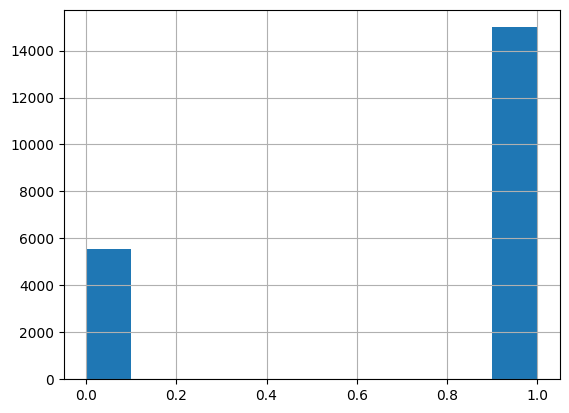

In [8]:
train_data['answerable'].hist()

<Axes: >

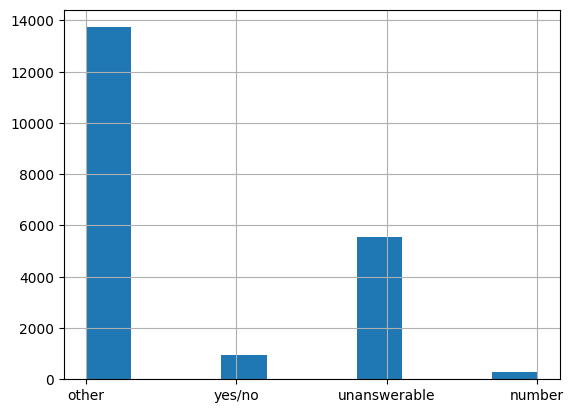

In [9]:
train_data.answer_type.hist()

<Axes: >

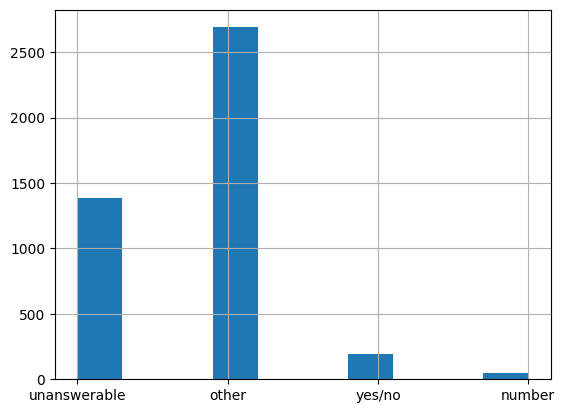

In [10]:
val_data.answer_type.hist()

<Axes: >

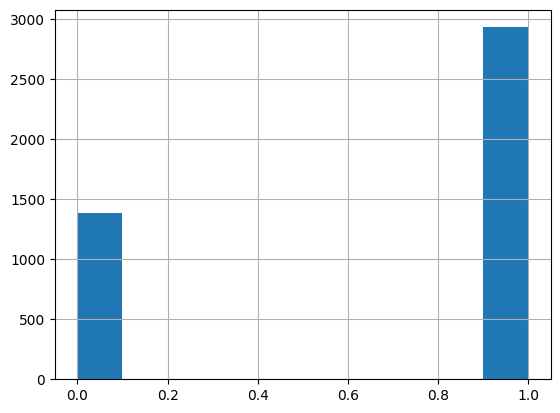

In [11]:
val_data.answerable.hist()

In [12]:
def most_common(lst):
    data = Counter(lst)
    return max(lst, key=data.get)

def is_answerable(ans):
    if ans == "unanswerable":
        return 0 
    return 1

In [13]:
# Selecting most common answer as the final answer
train_data['final_answer'] = train_data['answers'].apply(lambda x : most_common([ans['answer'] for ans in x]))
val_data['final_answer'] = val_data['answers'].apply(lambda x : most_common([ans['answer'] for ans in x]))

In [14]:
# Marking the unansweable answer flag as 0 
train_data['answerable'] = train_data['final_answer'].apply(lambda x : is_answerable(x))
val_data['answerable'] = val_data['final_answer'].apply(lambda x : is_answerable(x))

In [15]:
assert len(train_data['final_answer'] == "unanswerable") == len(train_data['answerable'] == 0)
assert len(val_data['final_answer'] == "unanswerable") == len(val_data['answerable'] == 0)

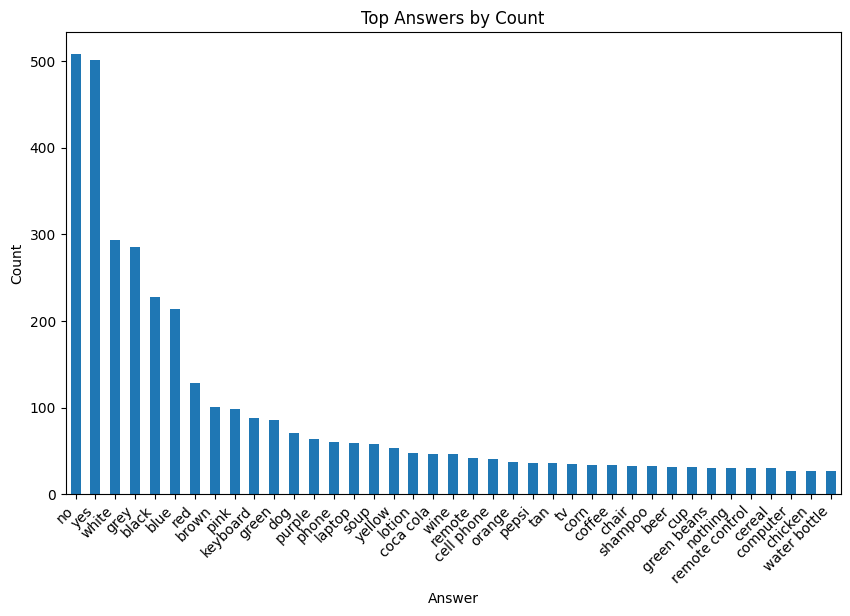

In [16]:
# Plotting top 40 answers
top_answers = train_data['final_answer'].value_counts()[1:40]

top_answers.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Answer')
plt.ylabel('Count')
plt.title('Top Answers by Count')
plt.xticks(rotation=45, ha='right')
plt.show()

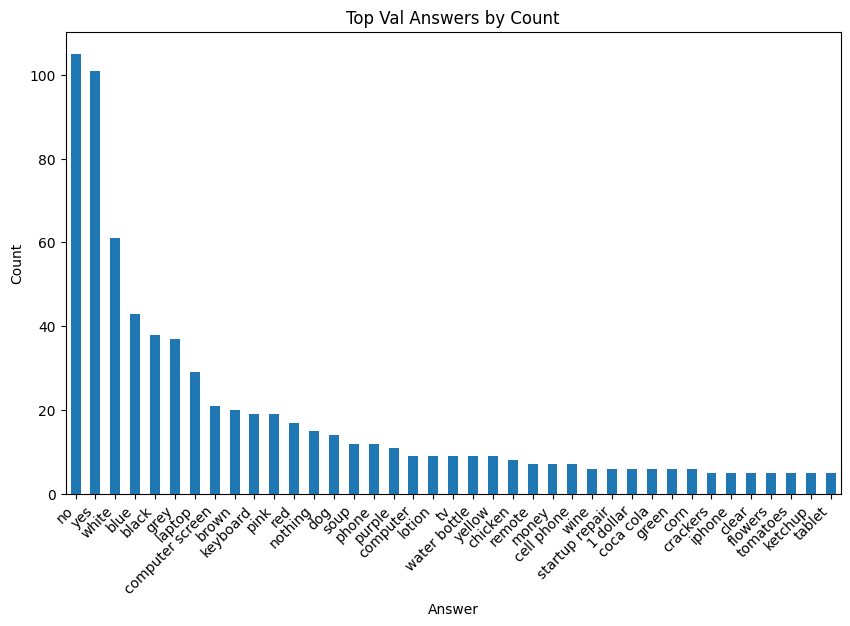

In [17]:
# Plotting top 40 answers
top_val_answers = val_data['final_answer'].value_counts()[1:40]

top_val_answers.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Answer')
plt.ylabel('Count')
plt.title('Top Val Answers by Count')
plt.xticks(rotation=45, ha='right')
plt.show()

In [18]:
# Adding image paths to dataframes
train_data['image_path'] = train_data['image'].apply(lambda x : data_dir+'/train/'+x)
val_data['image_path'] = val_data['image'].apply(lambda x : data_dir+'/val/'+x)

In [19]:
# Make sure image paths exist
for idx,row in train_data.iterrows():
    # print(row['image_path'])
    assert os.path.exists(row['image_path'])

for idx,row in val_data.iterrows():
    # print(row['image_path'])
    assert os.path.exists(row['image_path'])

In [20]:
train_data.to_json(os.path.join(data_dir, 'train_df.json'))
val_data.to_json(os.path.join(data_dir, 'val_df.json'))

In [21]:
def plot_random_images(df, num_images=10, figsize=(12, 8)):
    # Randomly select num_images rows from the DataFrame
    random_rows = df.sample(n=num_images)
    
    # Create a figure and axes
    fig, axes = plt.subplots(2, 5, figsize=figsize)
    axes = axes.flatten()
    
    # Iterate over the randomly selected rows
    for i, (_, row) in enumerate(random_rows.iterrows()):
        image_path = row['image_path']
        question = row['question']
        answer = row['final_answer']
        
        # Load and display the image
        img = mpimg.imread(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        
        # Wrap the question into multiple lines
        wrapped_question = textwrap.fill(question, width=30)
        
        # Set the title as the wrapped question
        axes[i].set_title(f"Q: {wrapped_question}", fontsize=8)
        
        # Set the answer as the text below the image
        axes[i].text(0.5, -0.1, f"A: {answer}", ha='center', va='center', transform=axes[i].transAxes, fontsize=8)
    
    # Adjust the spacing between subplots
    plt.tight_layout()
    plt.show()

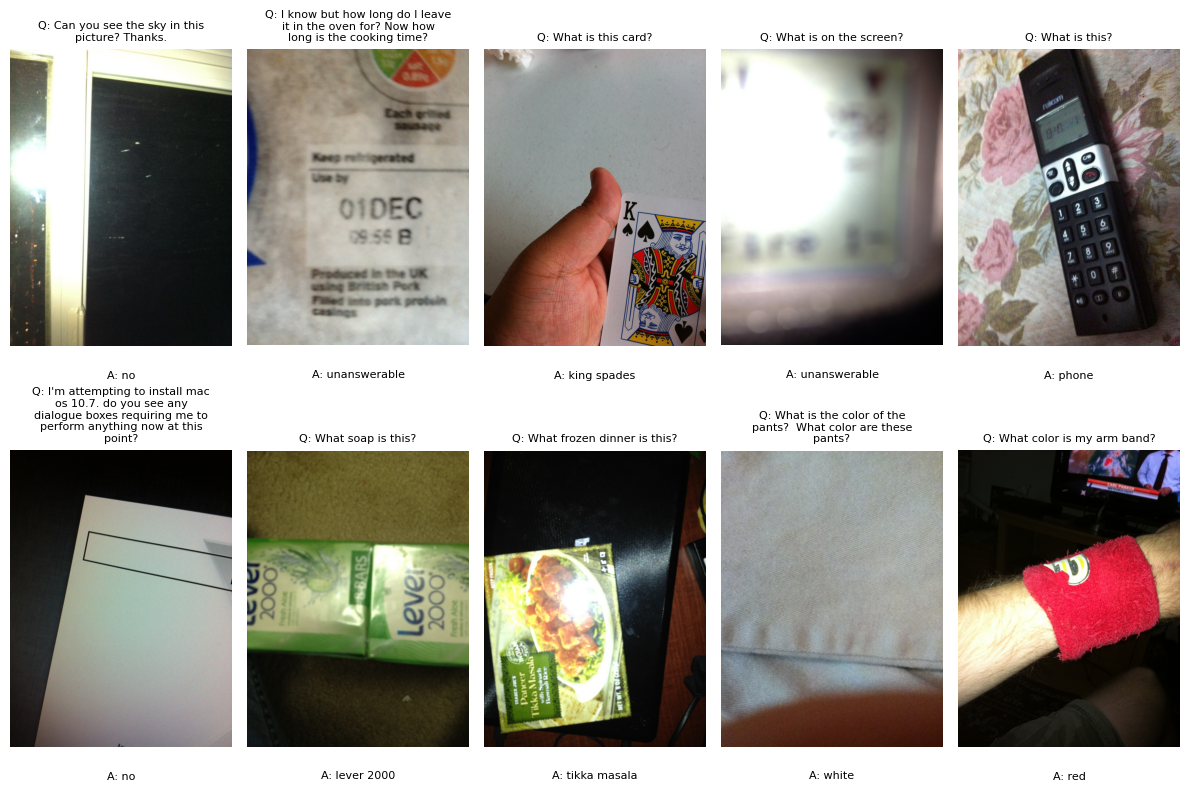

In [22]:
plot_random_images(train_data)

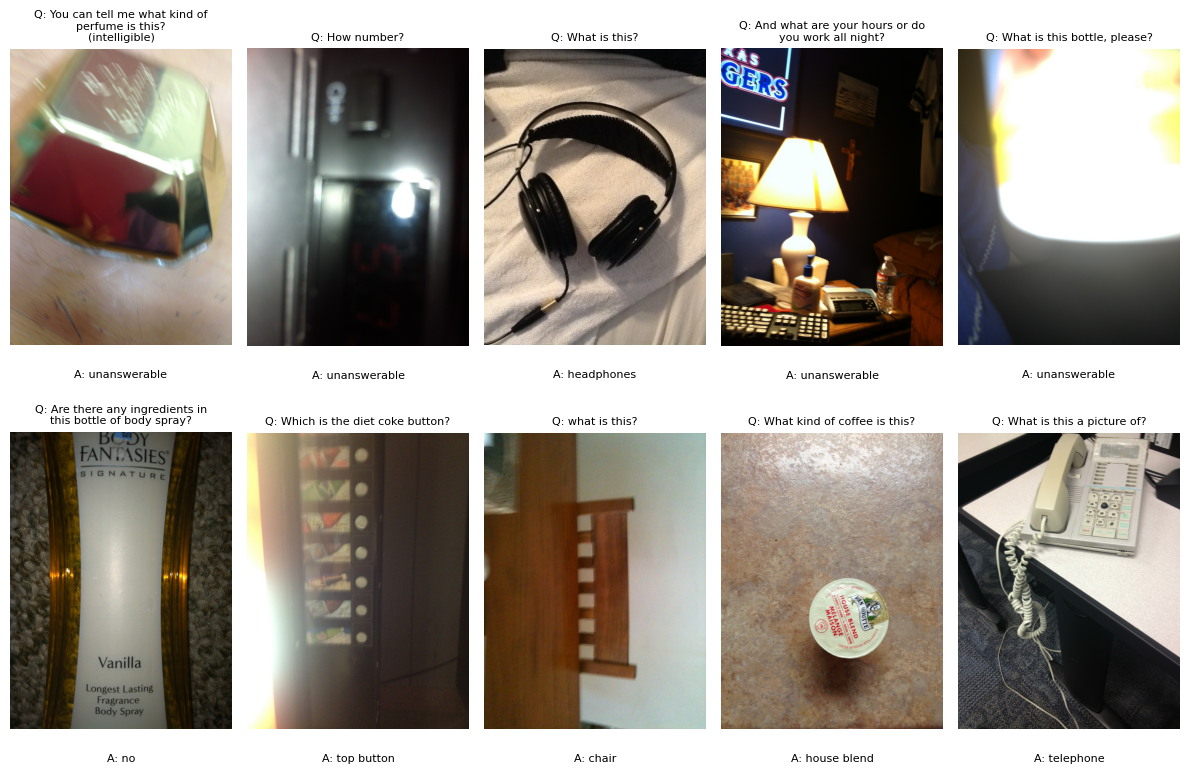

In [23]:
plot_random_images(train_data)